# Autoencoders for Anomaly Detection

## **Dataset**
- [Numenta Anomaly Benchmark](https://www.kaggle.com/datasets/boltzmannbrain/nab): dataset for evaluating anomaly detection algorithms, featuring a variety of time-series data from different domains, including financial market data.

In [7]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is not available.


## **Step 1:** Data Loading and Exploration

In [8]:
path = 'C:/Users/hansm/OneDrive/Documents/DL/Assignment2/archive/realTraffic/realTraffic'
data = pd.DataFrame(columns=['sensor', 'metric', 'timestamp', 'value'])

data_frames = []

for file in os.listdir(path): # listing all files within the given path directory
    if os.path.splitext(file)[-1] == '.csv': # extracting only csv files
        file_path = os.path.join(path, file) # concatentating the full path for the csv file
        temp = pd.read_csv(file_path) # temporary dataframe created from the csv

        # extracting the sensor and metric from the file's name
        file_name = re.split(r"[_.]", file) # splits the file name on every instance of the '_' or '.' symbols
        temp['metric'] = file_name[0]
        temp['sensor'] = file_name[1]
        data_frames.append(temp)

# ...add data straight to the dataframe...
data = pd.concat(data_frames, ignore_index = True)

# ensures the timestamp column is in datetime format
data['timestamp']= pd.to_datetime(data['timestamp'], format = 'mixed')

data.head()

,timestamp,value,metric,sensor
0,2015-09-01 13:45:00,3.06,occupancy,6005
1,2015-09-01 13:50:00,6.44,occupancy,6005
2,2015-09-01 13:55:00,5.17,occupancy,6005
3,2015-09-01 14:00:00,3.83,occupancy,6005
4,2015-09-01 14:05:00,4.50,occupancy,6005


In [9]:
# splitting up the timestamp variable into month, day, weekday, and hour
# note that we are excluding year, because all datapoints are from 2015
# note that we are excluding minute, because we deem it insignificant information, it may be added in later though
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day
data['weekday'] = data['timestamp'].dt.weekday
data['hour'] = data['timestamp'].dt.hour # 0 = Monday, 6 = Sunday
data.head()

,timestamp,value,metric,sensor,month,day,weekday,hour
0,2015-09-01 13:45:00,3.06,occupancy,6005,9,1,1,13
1,2015-09-01 13:50:00,6.44,occupancy,6005,9,1,1,13
2,2015-09-01 13:55:00,5.17,occupancy,6005,9,1,1,13
3,2015-09-01 14:00:00,3.83,occupancy,6005,9,1,1,14
4,2015-09-01 14:05:00,4.50,occupancy,6005,9,1,1,14


In [10]:
# summary statistics for each csv file
# note that each sensor-metric pairing has different ranges
sensor_metric_pairing = data.groupby(['sensor', 'metric']).describe()
sensor_metric_pairing

timestamp                                 \
                      count                           mean   
sensor metric                                                
387    TravelTime      2500     2015-08-21 19:04:22.704000   
451    TravelTime      2162  2015-08-25 20:34:49.925994240   
6005   occupancy       2380  2015-09-11 03:34:01.285714432   
       speed           2500     2015-09-10 16:08:31.056000   
7578   speed           1127  2015-09-13 18:08:14.374445568   
t4013  occupancy       2500     2015-09-10 20:57:29.832000   
       speed           2495  2015-09-10 20:45:05.555110144   

                                                             \
                                   min                  25%   
sensor metric                                                 
387    TravelTime  2015-07-10 14:24:00  2015-08-07 12:25:00   
451    TravelTime  2015-07-28 11:56:00  2015-08-11 10:34:15   
6005   occupancy   2015-09-01 13:45:00  2015-09-08 12:26:15   
       speed       2015-08-31 18:22:00  2015-09-04 14:15:45   
7578   speed       2015-09-08 11:39:00  2015-09-11 13:04:00   
t4013  occupancy   2015-09-01 11:30:00  2015-09-04 20:26:45   
       speed       2015-09-01 11:25:00  2015-09-04 20:20:30   

                                                             \
                                   50%                  75%   
sensor metric                                                 
387    TravelTime  2015-08-26 11:26:00  2015-09-07 17:37:30   
451    TravelTime  2015-08-26 12:55:00  2015-09-10 08:57:30   
6005   occupancy   2015-09-12 09:31:00  2015-09-15 08:37:15   
       speed       2015-09-11 22:08:30  2015-09-15 06:06:15   
7578   speed       2015-09-14 09:53:00  2015-09-16 06:11:30   
t4013  occupancy   2015-09-12 01:28:30  2015-09-15 05:11:15   
       speed       2015-09-12 01:16:00  2015-09-15 05:03:00   

                                              value              ... weekday  \
                                   max  std   count        mean  ...     max   
sensor metric                                                    ...           
387    TravelTime  2015-09-17 17:10:00  NaN  2500.0  325.093600  ...     6.0   
451    TravelTime  2015-09-17 17:09:00  NaN  2162.0  327.221554  ...     6.0   
6005   occupancy   2015-09-17 16:24:00  NaN  2380.0    4.495147  ...     6.0   
       speed       2015-09-17 16:24:00  NaN  2500.0   81.906800  ...     6.0   
7578   speed       2015-09-17 14:05:00  NaN  1127.0   64.048802  ...     6.0   
t4013  occupancy   2015-09-17 16:24:00  NaN  2500.0    7.242640  ...     6.0   
       speed       2015-09-17 16:19:00  NaN  2495.0   62.934269  ...     6.0   

                               hour                                          \
                        std   count       mean  min   25%   50%   75%   max   
sensor metric                                                                 
387    TravelTime  1.810981  2500.0  13.780800  0.0  11.0  15.0  17.0  23.0   
451    TravelTime  1.858946  2162.0  12.589269  0.0   9.0  12.0  17.0  23.0   
6005   occupancy   1.644680  2380.0  12.419748  0.0   8.0  13.0  17.0  23.0   
       speed       1.658018  2500.0  12.287600  0.0   8.0  13.0  17.0  23.0   
7578   speed       1.719616  1127.0  13.730257  0.0  10.0  14.0  17.0  23.0   
t4013  occupancy   1.660343  2500.0  12.688000  0.0   8.0  13.0  17.0  23.0   
       speed       1.660630  2495.0  12.696593  0.0   8.0  13.0  17.0  23.0   

                             
                        std  
sensor metric                
387    TravelTime  4.995471  
451    TravelTime  5.464676  
6005   occupancy   6.082302  
       speed       6.114560  
7578   speed       4.757344  
t4013  occupancy   5.936662  
       speed       5.926891  

[7 rows x 48 columns]

In [11]:
# summary statistics for each metric, merging results from different sensors (which were in different locations)
data.groupby(['metric']).agg(mean=('value', 'mean'), min=('value', 'min'), max=('value', 'max'), std=('value', 'std'), count=('value', 'count'))

,mean,min,max,std,count
metric,,,,,
TravelTime,326.080438,9.0,5578.00,421.070227,4662
occupancy,5.902674,0.0,43.06,4.162923,4880
speed,70.887128,1.0,109.00,11.912310,6122


- About the dataset: This dataset contains real-time traffic data from the Twin Cities Metro area in Minnesota. There are 2 csv files containing occupancy data (the average number of vehicles on the road), 3 csv files containing speed data (the average speed of the vehicles), and 2 csv files containing average travel time data. This information was collected from 5 different sensors placed throughout the city.

- Data type: These 7 csv files contain time-series data from approximately September 1st, 2015 until September 17th, 2015. The timesteps range from 5 minutes to several hours, resulting in some metrics not having a value for a specific time step.

- File information: Each csv file contains a timestamp column and a value column. Information about the metric collected and the sensor used is found in the name of each csv file.time

## **STEP 2:** Cleaning the Data

- Handling missing values
- Normalization
- Feature engineering

In [15]:
# Checking for missing values
print(data.isnull().sum())

timestamp    0
value        0
metric       0
sensor       0
month        0
day          0
weekday      0
hour         0
dtype: int64


In [16]:
# Normalizing the data
scaler = MinMaxScaler()
data['value'] = scaler.fit_transform(data[['value']])

## **STEP 3:** Data Visualization

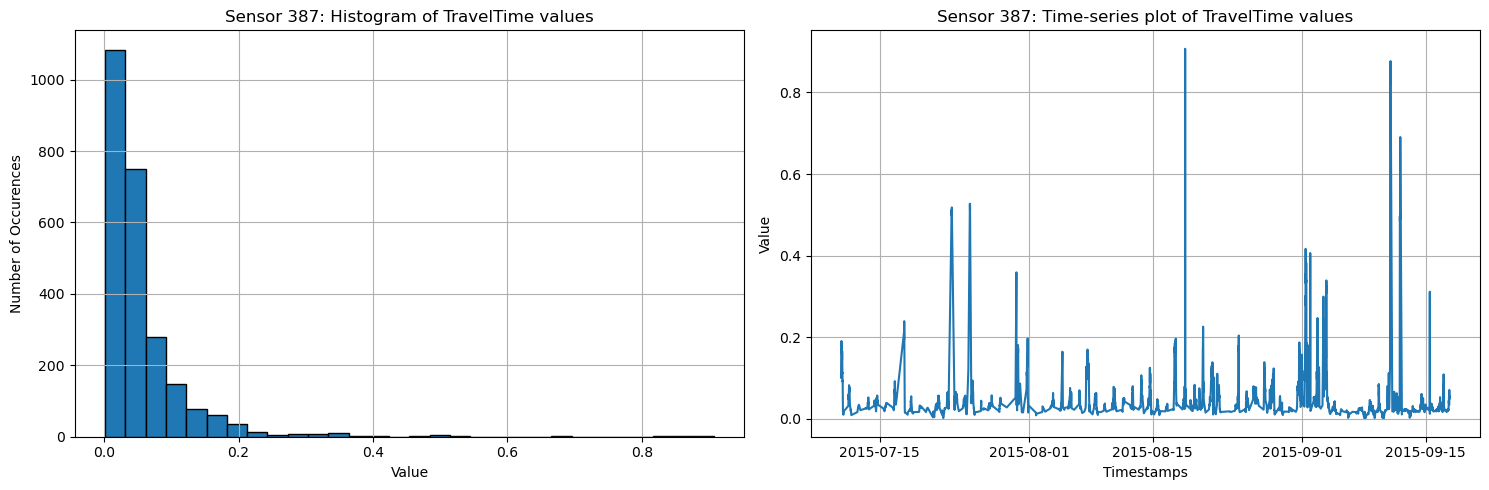

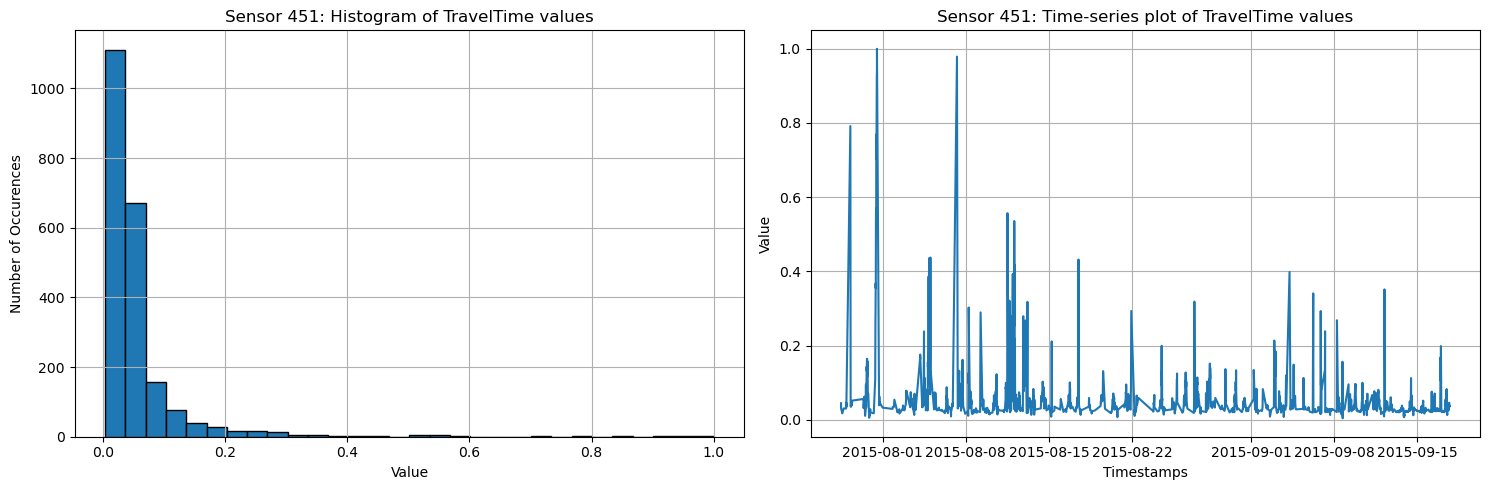

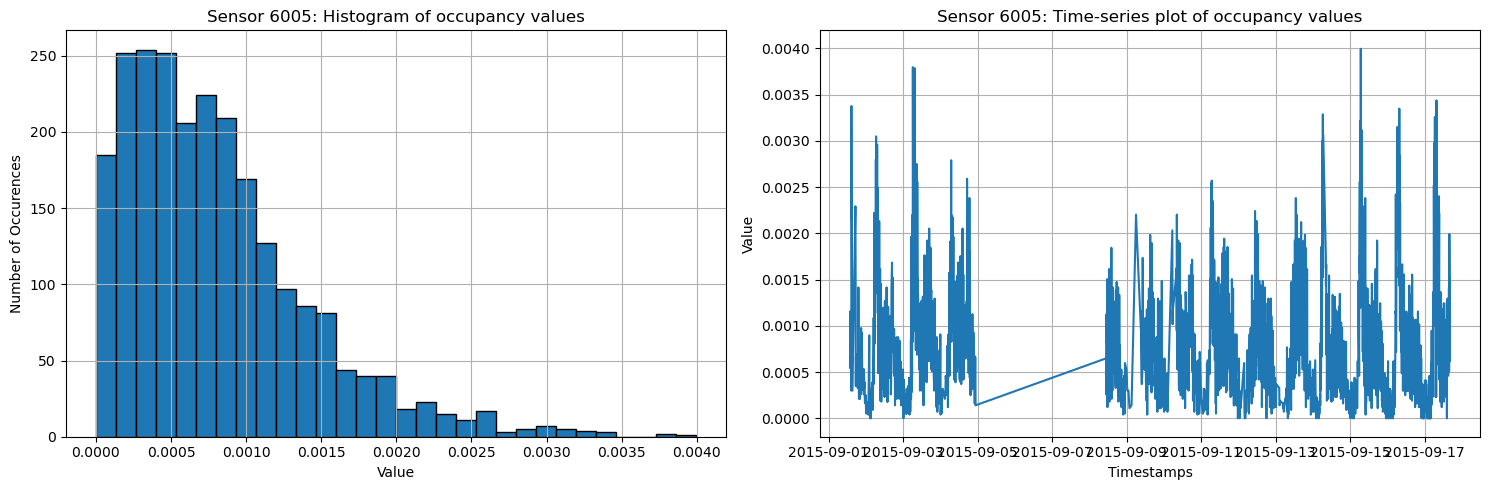

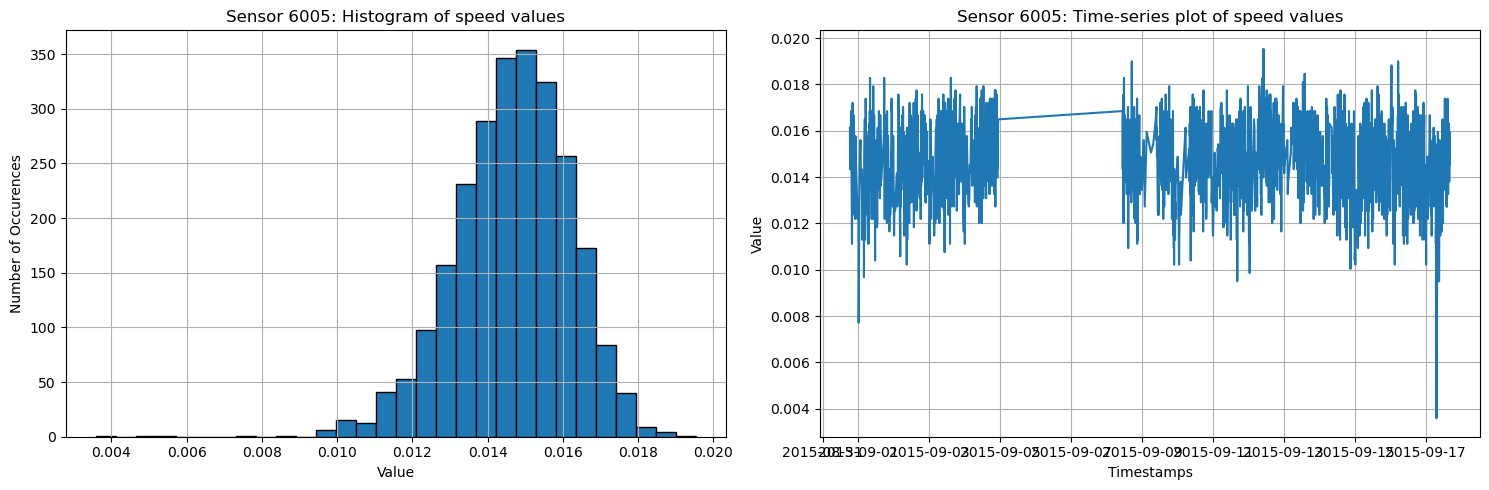

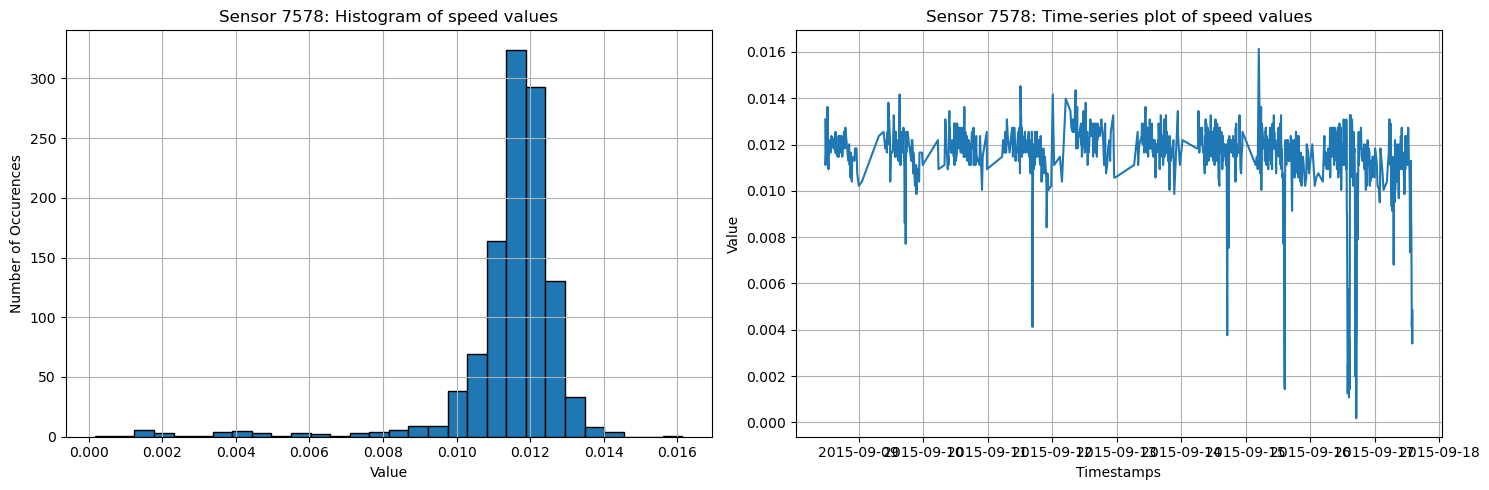

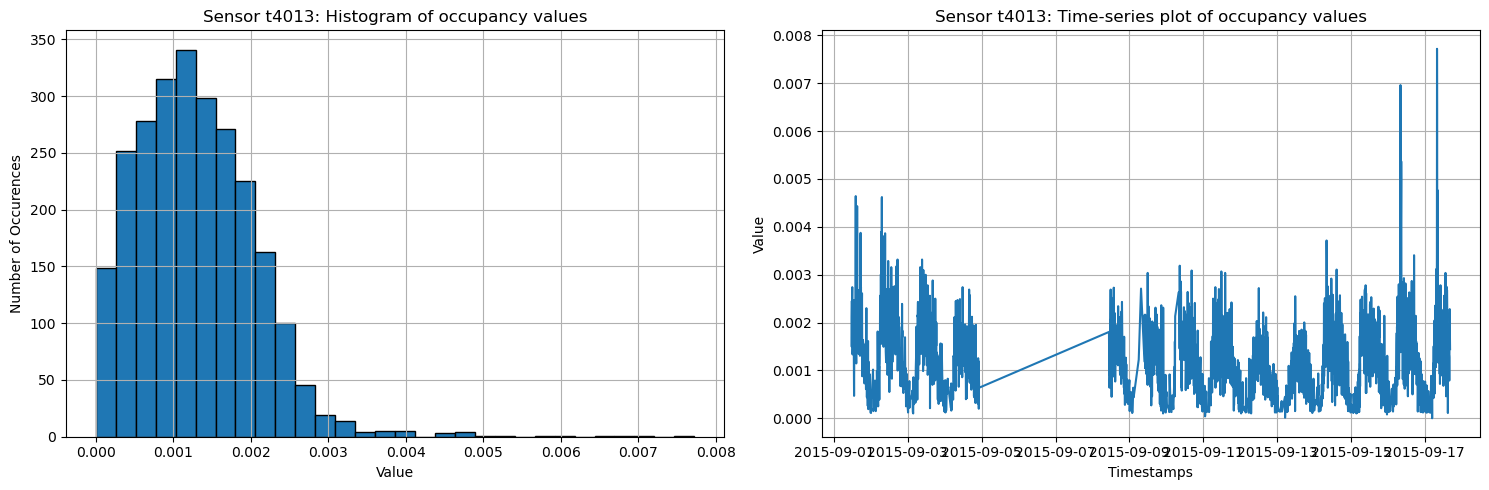

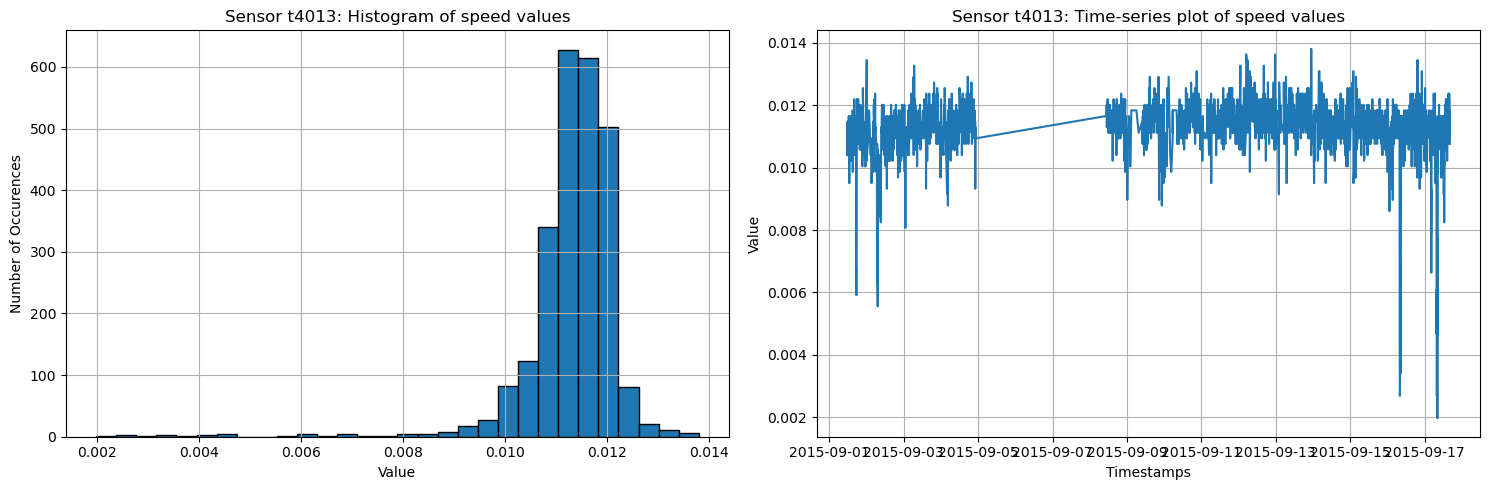

In [18]:
# Switching the order of steps 3 and 2 so that the data's actual values can be used for visualization.
# Normalized data may be difficult to visually interpret.
for sensor, metric in sensor_metric_pairing.index:
    # if (metric == 'speed') & (sensor == '7578'):
        values = data[(data['sensor'] == sensor) & (data['metric'] == metric)]['value']
        timestamps = data[(data['sensor'] == sensor) & (data['metric'] == metric)]['timestamp']

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.hist(values, bins = 30, edgecolor = 'k')
        plt.title(f'Sensor {sensor}: Histogram of {metric} values')
        plt.xlabel('Value')
        plt.ylabel('Number of Occurences')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(timestamps, values, linestyle = '-')
        plt.title(f'Sensor {sensor}: Time-series plot of {metric} values')
        plt.xlabel('Timestamps')
        plt.ylabel('Value')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

After visualizing the data, it becomes clear that we are dealing with 7 unique datasets. Each metric (TravelTime, occupancy, and speed) have unqiue ranges. Additionally, even collections of the same metric from different sensors have unique ranges and patterns, as each sensor was in a different location. Therefore, we will select only occupancy values (from sensor 6005 and t4013) to begin our anomaly detection.

In [20]:
occupancy_t4013 = data[(data['sensor'] == 't4013') & (data['metric'] == 'occupancy')]
occupancy_6005 = data[(data['sensor'] == '6005') & (data['metric'] == 'occupancy')]

occupancy_t4013.reset_index(drop=True, inplace=True)
occupancy_6005.reset_index(drop=True, inplace=True)

occupancy_6005.head()

,timestamp,value,metric,sensor,month,day,weekday,hour
0,2015-09-01 13:45:00,0.000549,occupancy,6005,9,1,1,13
1,2015-09-01 13:50:00,0.001155,occupancy,6005,9,1,1,13
2,2015-09-01 13:55:00,0.000927,occupancy,6005,9,1,1,13
3,2015-09-01 14:00:00,0.000687,occupancy,6005,9,1,1,14
4,2015-09-01 14:05:00,0.000807,occupancy,6005,9,1,1,14


C:\Users\hansm\AppData\Local\Temp\ipykernel_4292\163842292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupancy_6005['Isolation Forest Anomaly'] = isolation_forest_model.predict(occupancy_6005[['value']])
C:\Users\hansm\AppData\Local\Temp\ipykernel_4292\163842292.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupancy_6005['Isolation Forest Anomaly'] = occupancy_6005['Isolation Forest Anomaly'].apply(lambda x: True if x == -1 else False)


Number of anomalies in occupancy_6005: 24


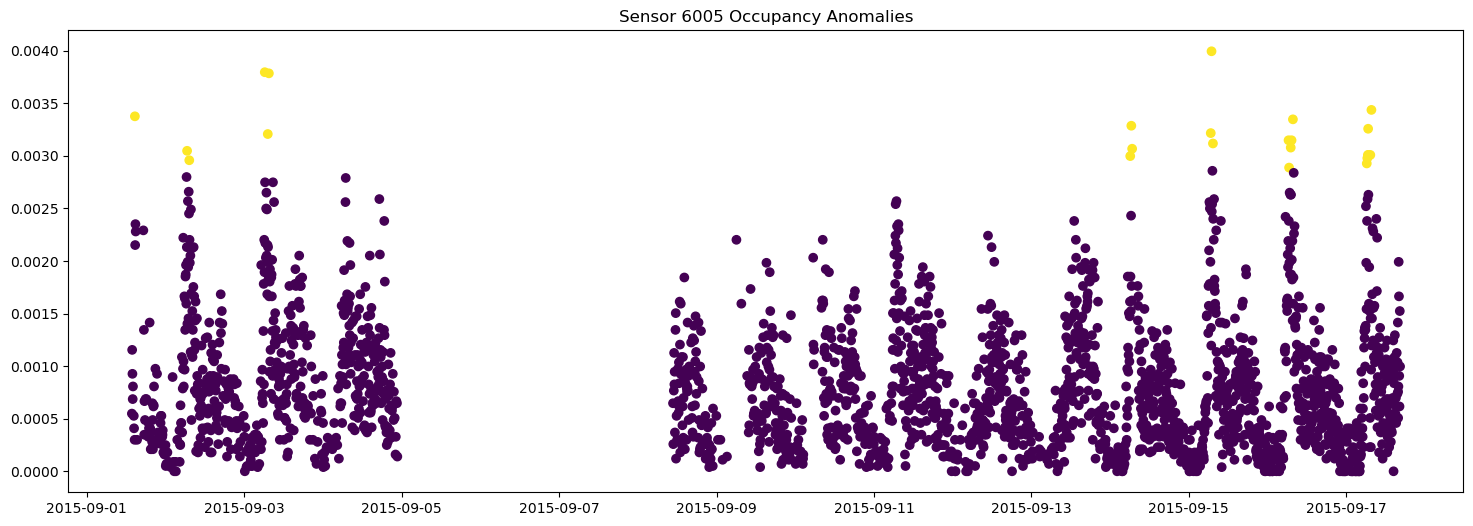

In [21]:
# to begin, let's look at a visual representation of the proposed anomalies from the Isolation Forest algorithm
isolation_forest_model = IsolationForest(contamination = 0.01)
isolation_forest_model.fit(occupancy_6005[['value']])

occupancy_6005['Isolation Forest Anomaly'] = isolation_forest_model.predict(occupancy_6005[['value']])
occupancy_6005['Isolation Forest Anomaly'] = occupancy_6005['Isolation Forest Anomaly'].apply(lambda x: True if x == -1 else False)
occupancy_6005_anomalies = occupancy_6005['Isolation Forest Anomaly'].sum()
print(f'Number of anomalies in occupancy_6005: {occupancy_6005_anomalies}')

plt.figure(figsize=(18, 6))
plt.scatter(occupancy_6005['timestamp'], occupancy_6005['value'], c = occupancy_6005['Isolation Forest Anomaly'])
plt.title('Sensor 6005 Occupancy Anomalies')

plt.show()

## **STEP 4:** Preparing the Datasets

- Splitting the dataset into training, validation and test sets.

In [23]:
# X = occupancy_6005[['month', 'day', 'weekday', 'hour']]
# Y = occupancy_6005[['value']]
# X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size = 0.4)
# X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size = 0.5)

# print(f'X_train and Y_train lengths: {len(X_train)} | {len(Y_train)}')
# print(f'X_val and Y_val lengths: {len(X_val)} | {len(Y_val)}')
# print(f'X_test and Y_test lengths: {len(X_test)} | {len(Y_test)}')

In [24]:
def create_windows(data, window_size):
    windows = []
    for i in range(0, len(data) - window_size + 1, window_size):
        windows.append(data[i:i + window_size])
    return np.array(windows)

window_size = 100

train_values = occupancy_t4013['value'].values
val_test_values = occupancy_6005['value'].values

train_windows = create_windows(train_values, window_size)
val_test_windows = create_windows(val_test_values, window_size)

train_windows = torch.tensor(train_windows, dtype=torch.float32)
val_test_windows = torch.tensor(val_test_windows, dtype=torch.float32)

In [25]:
# train_size = int(len(windows)*0.6)
# val_size = int(len(windows)*0.2)
# test_size = len(windows) - train_size - val_size
# print(f'train_size: {train_size} | val_size: {val_size} | test_size: {test_size}')

# could randomly sample the windows... not sure
# train_windows = windows[:train_size]
# val_windows = windows[train_size:train_size + val_size]
# test_windows = windows[train_size + val_size:]

# train_windows = torch.tensor(train_windows, dtype=torch.float32)
# val_windows = torch.tensor(val_windows, dtype=torch.float32)
# test_windows = torch.tensor(test_windows, dtype=torch.float32)

# print(train_windows[3].shape)

In [26]:
# values = occupancy_6005[['value']].values
# dataset = torch.tensor(values, dtype=torch.float32)

# train_size = int(len(dataset)*0.6)
# val_size = int(len(dataset)*0.2)
# test_size = len(dataset) - train_size - val_size
# print(f'train_size: {train_size} | val_size: {val_size} | test_size: {test_size}')

# train_data = occupancy_6005[:train_size]
# val_data = occupancy_6005[train_size:train_size + val_size]
# test_data = occupancy_6005[train_size + val_size:]

# train = torch.tensor(train_data['value'].values, dtype=torch.float32).view(1, -1)
# val = torch.tensor(val_data['value'].values, dtype=torch.float32).view(1, -1)
# test = torch.tensor(test_data['value'].values, dtype=torch.float32).view(1, -1)

In [27]:
# batch_size = 32
# train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [28]:
# no_train_batches = len(train_dataloader)
# no_val_batches = len(val_dataloader)
# no_test_batches = len(test_dataloader)
# print(f"Length of train dataloader: {no_train_batches} batches of {batch_size}")
# print(f"Length of val dataloader: {no_val_batches} batches of {batch_size}")
# print(f"Length of test dataloader: {no_test_batches} batches of {batch_size}")

## **STEP 5:** Building an Autoencoder

In [31]:
class autoencoder_1(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [32]:
class autoencoder_2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size // 8, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [33]:
# class LSTM_Autoencoder(nn.Module):
#     def __init__(self, seq_len, n_features, embedding_dim=64):
#         super(LSTM_Autoencoder, self).__init__()
#         self.seq_len, self.n_features = seq_len, n_features
#         self.embedding_dim, self.hidden_dim = embedding_dim, embedding_dim
        
#         self.encoder_lstm = nn.LSTM(
#             input_size=n_features,
#             hidden_size=self.hidden_dim,
#             num_layers=1,
#             batch_first=True
#         )
        
#         self.decoder_lstm = nn.LSTM(
#             input_size=self.hidden_dim,
#             hidden_size=n_features,
#             num_layers=1,
#             batch_first=True
#         )
        
#     def forward(self, x):

#         x, (hidden_n, _) = self.encoder_lstm(x)
#         x, (hidden_n, _) = self.decoder_lstm(hidden_n)
#         x = x.repeat(1, self.seq_len, 1)
        
#         return x

## **STEP 6:** Experimenting with Architectures

#### EXPERIMENT #1

In [36]:
# Function to train the model
def train_model(model, train_windows, val_test_windows, num_epochs, optimizer, loss_function):
    train_loss, val_loss = [], [] # initializing loss lists
    previous_val_loss = float('inf')
    val_patience = 100
    val_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_running_loss = 0.0

        inputs = train_windows.to(device)

        optimizer.zero_grad() # zeroing the parameters

        outputs = model(inputs) # forward pass through the model

        loss = loss_function(outputs, inputs) # calculating the loss

        train_running_loss += loss.item()

        loss.backward() # backpropogation
        optimizer.step()

        # calculating/appending epoch loss
        epoch_loss = train_running_loss
        train_loss.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0

        with torch.no_grad():
            inputs = val_test_windows.to(device)
            outputs = model(inputs) # forward pass
            loss = loss_function(outputs, inputs) # loss calculation
            val_running_loss += loss.item()

        # calculating/appending epoch loss
        val_epoch_loss = val_running_loss
        val_loss.append(val_epoch_loss)

        if (epoch+1)%1000 == 0:
            print(f'Epoch {epoch+1:5d} | Train Loss: {epoch_loss:.10f} | Val Loss: {val_epoch_loss:.10f}')

        # Early stopping
        if val_loss[-1] >= previous_val_loss:
            val_counter += 1
            if val_counter >= val_patience:
                print('Early stopping condition met. Validation loss is increasing/stagnating.')
                break
        else:
            previous_val_loss = val_loss[-1]
            val_counter = 0

    return train_loss, val_loss

In [37]:
def plot_metrics(train_losses, val_losses, experiment_num):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title(f'Experiment {experiment_num} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Epoch  1000 | Train Loss: 0.0000020468 | Val Loss: 0.0000038627
Epoch  2000 | Train Loss: 0.0000007438 | Val Loss: 0.0000008243
Epoch  3000 | Train Loss: 0.0000007123 | Val Loss: 0.0000008187
Epoch  4000 | Train Loss: 0.0000007035 | Val Loss: 0.0000008154
Epoch  5000 | Train Loss: 0.0000007002 | Val Loss: 0.0000008122
Epoch  6000 | Train Loss: 0.0000006964 | Val Loss: 0.0000008073
Epoch  7000 | Train Loss: 0.0000006906 | Val Loss: 0.0000007996
Epoch  8000 | Train Loss: 0.0000006815 | Val Loss: 0.0000007872
Epoch  9000 | Train Loss: 0.0000006672 | Val Loss: 0.0000007668
Epoch 10000 | Train Loss: 0.0000006441 | Val Loss: 0.0000007318
Epoch 11000 | Train Loss: 0.0000006010 | Val Loss: 0.0000006627
Epoch 12000 | Train Loss: 0.0000005173 | Val Loss: 0.0000005076
Epoch 13000 | Train Loss: 0.0000004778 | Val Loss: 0.0000003998
Epoch 14000 | Train Loss: 0.0000004729 | Val Loss: 0.0000003755
Epoch 15000 | Train Loss: 0.0000004713 | Val Loss: 0.0000003697
Epoch 16000 | Train Loss: 0.0000004695 |

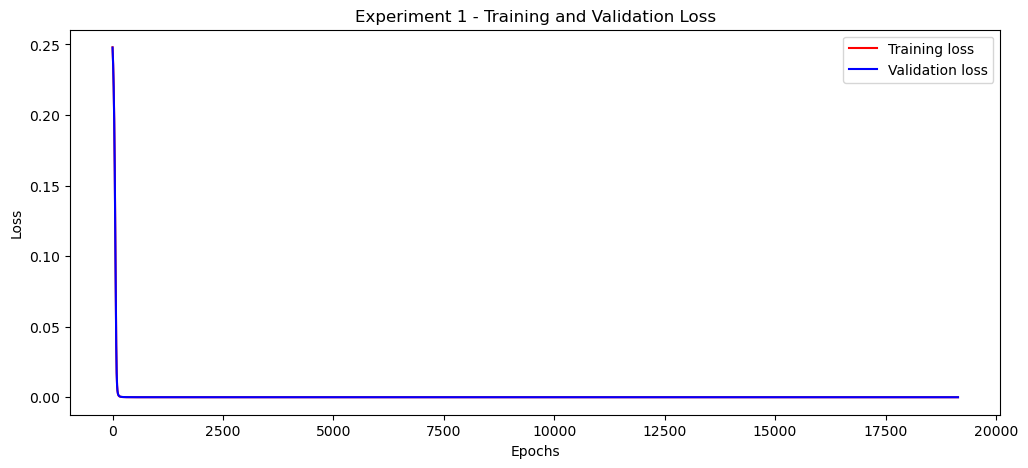

In [38]:
input_size = window_size
hidden_size = 40
learning_rate = 0.001
num_epochs = 20000

model_1 = autoencoder_1(input_size, hidden_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = learning_rate)

train_loss, val_loss = train_model(model_1, train_windows, val_test_windows, num_epochs, optimizer, loss_function)
plot_metrics(train_loss, val_loss, experiment_num = 1)

#### EXPERIMENT #2

Epoch  1000 | Train Loss: 0.0000976932 | Val Loss: 0.0001179460
Epoch  2000 | Train Loss: 0.0000119897 | Val Loss: 0.0000171810
Epoch  3000 | Train Loss: 0.0000035023 | Val Loss: 0.0000057599
Epoch  4000 | Train Loss: 0.0000015227 | Val Loss: 0.0000026334
Epoch  5000 | Train Loss: 0.0000009377 | Val Loss: 0.0000014903
Epoch  6000 | Train Loss: 0.0000007532 | Val Loss: 0.0000010243
Epoch  7000 | Train Loss: 0.0000006933 | Val Loss: 0.0000008391
Epoch  8000 | Train Loss: 0.0000006720 | Val Loss: 0.0000007726
Epoch  9000 | Train Loss: 0.0000006608 | Val Loss: 0.0000007475
Epoch 10000 | Train Loss: 0.0000006458 | Val Loss: 0.0000007228
Epoch 11000 | Train Loss: 0.0000006147 | Val Loss: 0.0000006702
Epoch 12000 | Train Loss: 0.0000005652 | Val Loss: 0.0000005783
Epoch 13000 | Train Loss: 0.0000005132 | Val Loss: 0.0000004712
Epoch 14000 | Train Loss: 0.0000004823 | Val Loss: 0.0000003982
Epoch 15000 | Train Loss: 0.0000004748 | Val Loss: 0.0000003737
Epoch 16000 | Train Loss: 0.0000004739 |

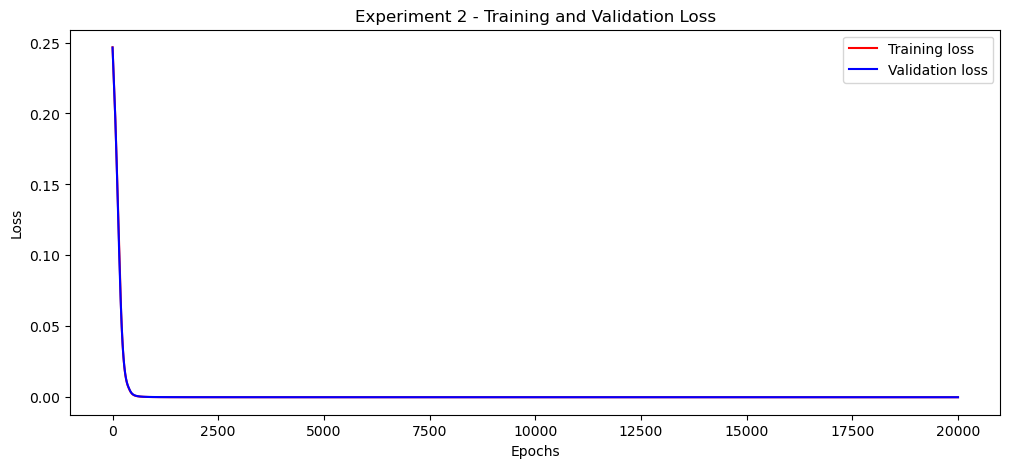

In [40]:
# Fewer unmber of hidden units
input_size = window_size
hidden_size = 10 # 40 -> 10
learning_rate = 0.001
num_epochs = 20000

model_2 = autoencoder_1(input_size, hidden_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = learning_rate)

train_loss, val_loss = train_model(model_2, train_windows, val_test_windows, num_epochs, optimizer, loss_function)
plot_metrics(train_loss, val_loss, experiment_num = 2)

#### EXPERIMENT #3

Early stopping condition met. Validation loss is increasing/stagnating.


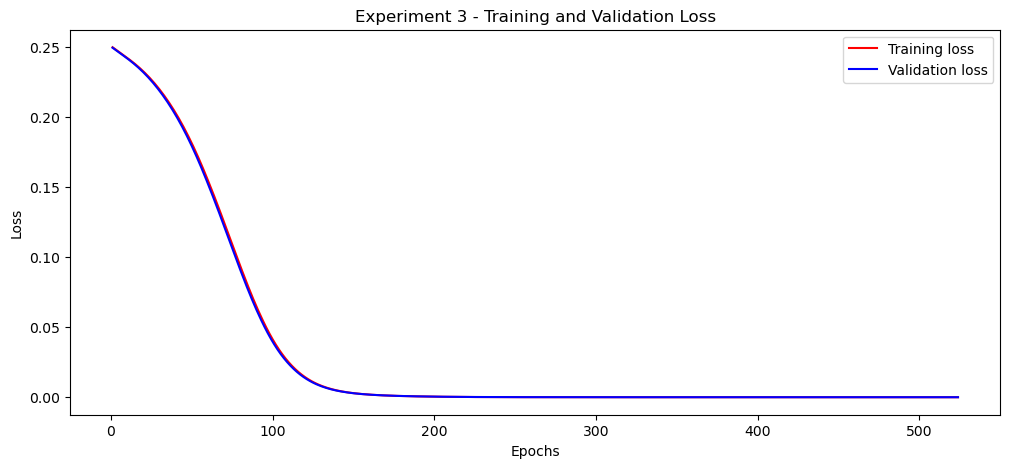

In [42]:
# Completely different architecture using autoencoder_2, and fewer hidden units
input_size = window_size
hidden_size = 32 # 40 -> 32
learning_rate = 0.001
num_epochs = 20000

model_3 = autoencoder_2(input_size, hidden_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr = learning_rate)

train_loss, val_loss = train_model(model_3, train_windows, val_test_windows, num_epochs, optimizer, loss_function)
plot_metrics(train_loss, val_loss, experiment_num = 3)

To begin, I implemented a very basic autoencoder consisting of a total of 4 layers (2 in the encoder and 2 in the decoder). Each subsequent layer in the encoder halves the number of neurons. It uses Relu activation functions after each layer except for the last layer, which uses a Sigmoid activation function.

Next, I implemented a more complicated autoencoder consisting of 8 layers (4 in the encoder and 4 in the decoder). Again, each layer in the encoder halves the number of neurons. Additionally, this also uses Relu activation functions for each layer, except for the output layer, which uses a Sigmoid activation function.

I considered implementing an LSTM autoencoder, considering the fact that I am working with time-series data. However, the sliding window approach to preparing the data is not compatible with the input needed for an LSTM autoencoder.


## **STEP 7:** Evaluating the Models

In [117]:
def eval_model(model, val_test_windows, dataset, threshold):
    
    model.eval()
    test_loss = 0
    anomalies = set()
    
    with torch.no_grad():
        test_output = model(val_test_windows)
        
        for i, window in enumerate(val_test_windows):
            mse_window = (window - test_output[i]) ** 2
            test_loss += mse_window.sum()
            
            for j, mse in enumerate(mse_window):
                if mse.item() > threshold:
                    value = window[j].item()
                    idx = dataset.index[np.isclose(dataset['value'], value, atol=0.000000000000000000001)].to_numpy()
                    anomalies.update(idx)
    
    anomaly_indices = sorted(anomalies)
    print(f'Reconstruction Error: {test_loss.item():.5f}')
    # print(f'List of Anomaly indices: {anomaly_indices}')
    print(f'Number of Anomalies: {len(anomalies)}')
    
    anomaly_rows = dataset.iloc[anomaly_indices]
    print(anomaly_rows['Isolation Forest Anomaly'])
    
    plt.figure(figsize=(18, 6))
    plt.scatter(dataset['timestamp'], dataset['value'], label = "Normal Data", color = 'blue')
    plt.scatter(dataset.iloc[anomaly_indices]['timestamp'], dataset.iloc[anomaly_indices]['value'], label='Anomalies', color='red', s=20)
    plt.title(f'occupancy_6005 with Labeled Anomalies')
    plt.show()

    # Creating a new column in the dataframe denoting whether the row is an anomaly or not based upon the autoencoder
    dataset.loc[:,'Autoencoder Anomaly'] = False
    dataset.loc[anomaly_indices, 'Autoencoder Anomaly'] = True

    isolation_labels = dataset['Isolation Forest Anomaly'].astype(int)  # converts True/False to 1/0
    autoencoder_labels = dataset['Autoencoder Anomaly'].astype(int)

    cm = confusion_matrix(isolation_labels, autoencoder_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Anomaly', 'Anomaly'], yticklabels=['Not Anomaly', 'Anomaly'])
    plt.xlabel('Autoencoder Anomaly')
    plt.ylabel('Isolation Forest Anomaly')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(isolation_labels, autoencoder_labels)
    print(f'Accuracy of Autoencoder (as compared to the Isolation Forest): {accuracy*100:.2f}%')

#### Experiment 1 Results

Reconstruction Error: 0.00083
Number of Anomalies: 45
8        True
85      False
87       True
90      False
93      False
95       True
261      True
262     False
266     False
271      True
275      True
289     False
439     False
531     False
973     False
976     False
1535     True
1539     True
1542     True
1759    False
1761     True
1764     True
1766    False
1767    False
1769     True
1773    False
1990    False
2000     True
2002     True
2004    False
2007    False
2008     True
2009    False
2011     True
2016     True
2019    False
2257     True
2259     True
2260    False
2261     True
2262     True
2263    False
2264     True
2270     True
2274     True
Name: Isolation Forest Anomaly, dtype: bool


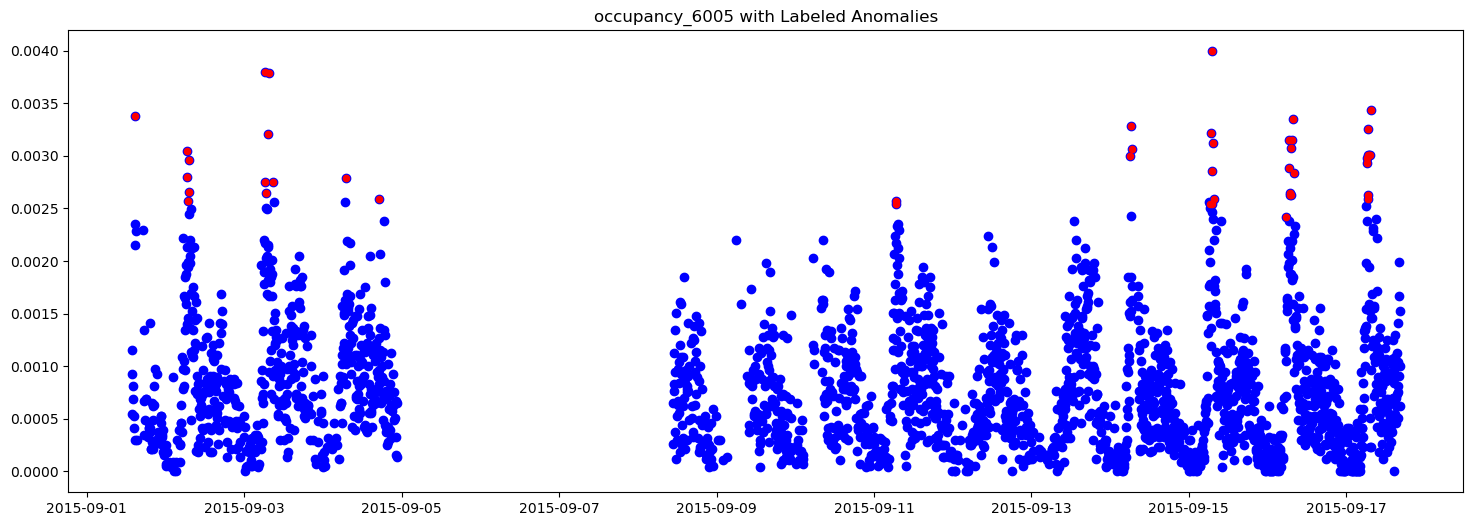

C:\Users\hansm\AppData\Local\Temp\ipykernel_4292\1824161841.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:,'Autoencoder Anomaly'] = False


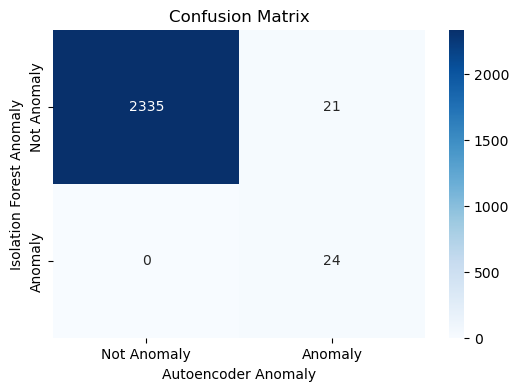

Accuracy of Autoencoder (as compared to the Isolation Forest): 99.12%


In [48]:
eval_model(model = model_1, val_test_windows = val_test_windows, dataset = occupancy_6005, threshold = 0.00000275)

#### Experiment 2 Results

Reconstruction Error: 0.00084
Number of Anomalies: 47
8        True
85      False
87       True
90      False
93      False
95       True
261      True
262     False
271      True
275      True
289     False
292     False
438     False
439     False
531     False
973     False
976     False
1535     True
1538    False
1539     True
1542     True
1756    False
1759    False
1761     True
1764     True
1766    False
1767    False
1769     True
1773    False
1990    False
2000     True
2002     True
2007    False
2008     True
2009    False
2011     True
2016     True
2019    False
2257     True
2259     True
2260    False
2261     True
2262     True
2263    False
2264     True
2270     True
2274     True
Name: Isolation Forest Anomaly, dtype: bool


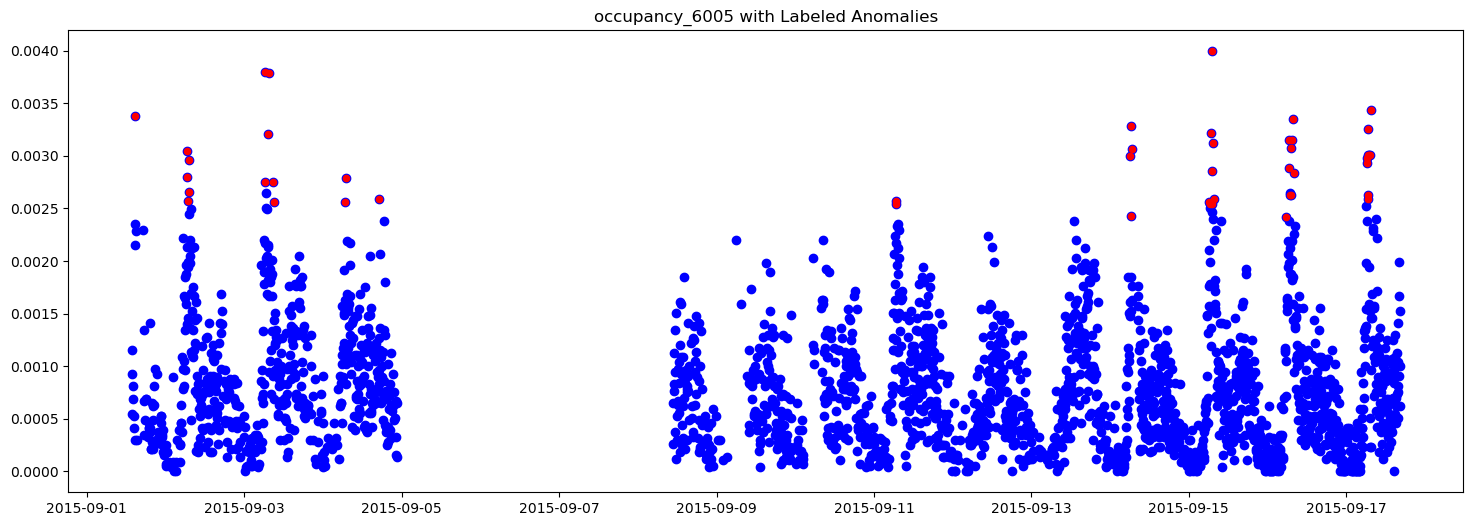

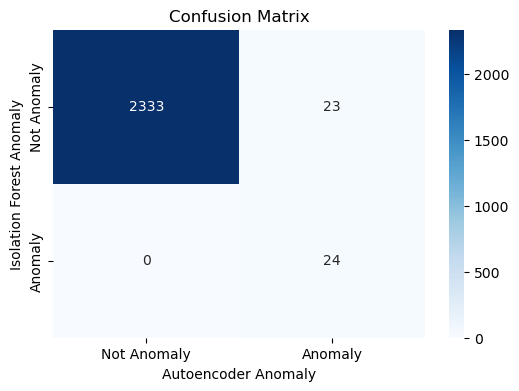

Accuracy of Autoencoder (as compared to the Isolation Forest): 99.03%


In [50]:
eval_model(model = model_2, val_test_windows = val_test_windows, dataset = occupancy_6005, threshold = 0.00000275)

#### Experiment 3 Results

Reconstruction Error: 0.00170
Number of Anomalies: 129
48      False
52      False
53      False
54      False
122     False
        ...  
2223    False
2234    False
2302    False
2314    False
2331    False
Name: Isolation Forest Anomaly, Length: 129, dtype: bool


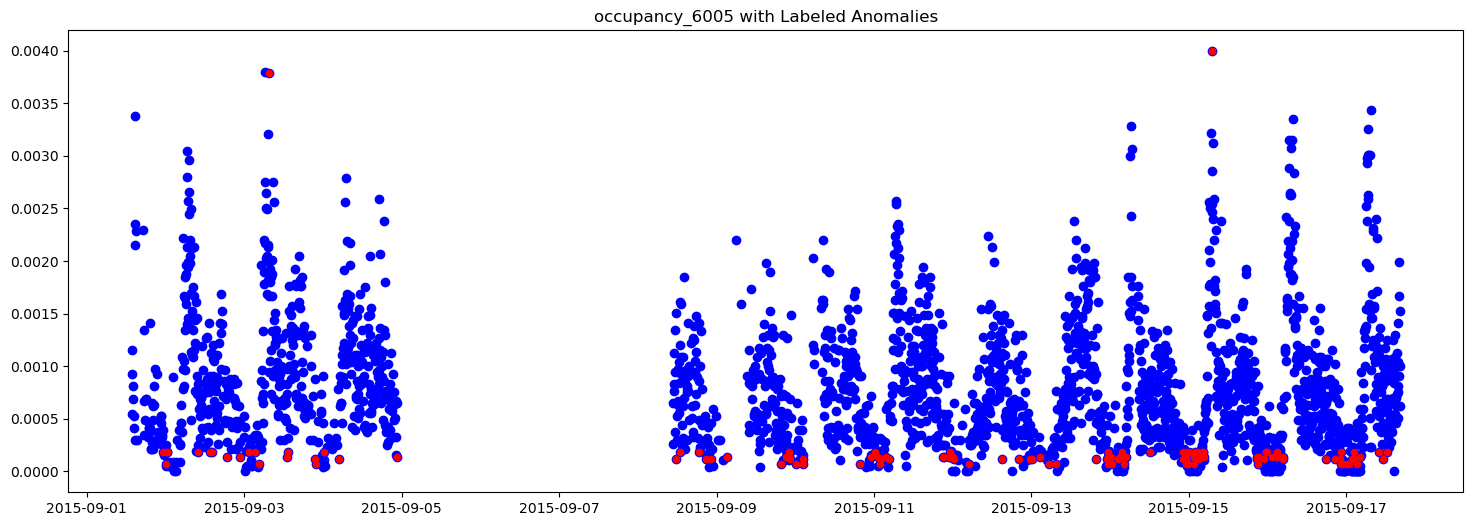

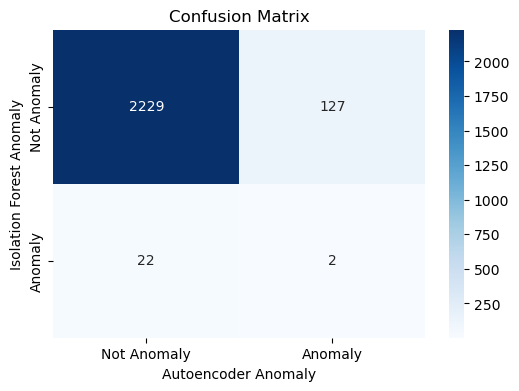

Accuracy of Autoencoder (as compared to the Isolation Forest): 93.74%


In [127]:
eval_model(model = model_3, val_test_windows = val_test_windows, dataset = occupancy_6005, threshold = 0.000006)

#### Saving the Model

In [112]:
torch.save(model_1.state_dict(), 'C:/Users/hansm/OneDrive/Documents/DL/Assignment2/jamatzal_chellapp_assignment2_part_3.pickle')

The training and validation graphs are very similar to each other for all three graphs, starting at a value around 0.25 and slowly diminishing the 0 over the course of the 20,000 total epochs. The line almost appears purple because the red line for the training loss and the blue line for the validation loss are plotted over each other.

The evaluation graphs for experiment one and two look good, with many of the higher value points on the scatter plot denoted as anomalies. Looking at the scatter plot of the data, this looks correct. However, the evaluation graph for experiment three shows that the model has identified the lowest points of the data as anomalies, instead of the highest point. Visually, this looks incorrect as there are many data points with similar low values. This is most likely because the training data which the model has been trained on is different from the evaluation data. The ranges and means are different for the two datasets, as they are taken from sensors in different locations.

My first experiment, using the first architecture appears to perform best, as it closely matches the results from the isolation forest. It has the lowest reconstruction loss of 0.00083, and a reported accuracy of 99.12% (as compared to the isolation forest). Additionally, visually, it appears to capture the majority of the outliers in the occupancy data. This is likely because it is a simple architecture consisting of 4 layers in total, as compared to the other 8 layer autoencoder.

However, the real cause is most likely the fact that this experiment performed less dimensionality reduction as compared the other two experiments. This architecture had a 20 neurons latent vector, as compared to the 5 and 4 neuron latent vectors of the second and third experiments.

One limitation of this autoencoder analysis is that the reported accuracy is arbitrary, and does not prove, by any means, that these points are truly outliers. The accuracy is merely a comparison to the results of the isolation forest, as no definitive labels were given by the dataset. Additionally, the method used to identify the outliers, using the reconstruction error, is highly dependent on the inputted threshold value. By slightly changing the threshold value, you can drastically change the number of points identified as outliers.

One strength of this autoencoder analysis is that it can be undertaken without predefined labels. It is not necessary to label which points are anomalous and which points are normal, that is, it is unsupervised learning. This eliminates the costly and time-intensive procedure of manually labeling data points.

#### Additional Evaluations

In [61]:
speed_6005 = data[(data['sensor'] == '6005') & (data['metric'] == 'speed')]
speed_7578 = data[(data['sensor'] == '7578') & (data['metric'] == 'speed')]
speed_t4013 = data[(data['sensor'] == 't4013') & (data['metric'] == 'speed')]
TravelTime_387 = data[(data['sensor'] == '387') & (data['metric'] == 'TravelTime')]
TravelTime_451 = data[(data['sensor'] == '451') & (data['metric'] == 'TravelTime')]
dataset_list = [speed_6005, speed_7578, speed_t4013, TravelTime_387, TravelTime_451]

In [62]:
def window_split(dataset, window_size=40):
    values = dataset['value'].values
    windows = create_windows(values, window_size)
    windows = torch.tensor(windows, dtype=torch.float32)

    return windows

In [63]:
def plot_metrics(train_losses, val_losses, sensor, metric):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title(f'{metric}_{sensor} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [64]:
def eval_model(model, test_windows, dataset, threshold):
    model.eval()
    test_loss = 0
    anomalies = set()
    with torch.no_grad():
        test_output = model(test_windows)
        
        for i, window in enumerate(test_windows):
            mse_window = (window - test_output[i]) ** 2
            test_loss += mse_window.sum()
            
            for j, mse in enumerate(mse_window):
                if mse.item() > threshold:
                    value = window[j].item()
                    idx = dataset.index[np.isclose(dataset['value'], value, atol=0.000000000000000000001)].to_numpy()
                    anomalies.update(idx)
    
    anomaly_indexes = sorted(anomalies)
    print(f'Reconstruction Error: {test_loss.item():.5f}')
    print(f'List of Anomaly indexes: {anomaly_indexes}')
    print(f'Number of Anomalies: {len(anomalies)}')

    # anomaly_rows = dataset.iloc[anomaly_indexes]
    metric_ = dataset['metric'][0]
    sensor_ = dataset['sensor'][0]
    
    plt.figure(figsize=(18, 6))
    plt.scatter(dataset['timestamp'], dataset['value'], label = "Normal Data", color = 'blue')
    plt.scatter(dataset.iloc[anomaly_indexes]['timestamp'], dataset.iloc[anomaly_indexes]['value'], label='Anomalies', color='red', s=20)
    plt.title(f'{metric_}_{sensor_} with Labeled Anomalies')

    plt.show()

In [65]:
def dataset_evaluation(dataset_list, window_size=100, hidden_size=32, threshold=0.000005, num_epochs=20000):

    for dataset in dataset_list:
        dataset.reset_index(drop=True, inplace=True)
        metric_ = dataset['metric'][0]
        sensor_ = dataset['sensor'][0]
        print(f'Training and Evaluation for the {metric_}_{sensor_} dataset')
        windows = window_split(dataset, window_size=100)

        # Initializing and training and model
        model = autoencoder_1(input_size = window_size, hidden_size = hidden_size)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
        train_loss, val_loss = train_model(model, windows, windows, num_epochs, optimizer, loss_function)
        plot_metrics(train_loss, val_loss, sensor_, metric_)

        # Evaluating the model
        if metric_ == 'speed':
            threshold = 0.000015
        else:
            threshold = 0.0001
        eval_model(model, windows, dataset, threshold)

Training and Evaluation for the speed_6005 dataset
Epoch  1000 | Train Loss: 0.0000032899 | Val Loss: 0.0000032899
Epoch  2000 | Train Loss: 0.0000032851 | Val Loss: 0.0000032851
Epoch  3000 | Train Loss: 0.0000032766 | Val Loss: 0.0000032766
Epoch  4000 | Train Loss: 0.0000032625 | Val Loss: 0.0000032625
Epoch  5000 | Train Loss: 0.0000032394 | Val Loss: 0.0000032394
Epoch  6000 | Train Loss: 0.0000032026 | Val Loss: 0.0000032026
Epoch  7000 | Train Loss: 0.0000031450 | Val Loss: 0.0000031450
Epoch  8000 | Train Loss: 0.0000030573 | Val Loss: 0.0000030572
Epoch  9000 | Train Loss: 0.0000029295 | Val Loss: 0.0000029293
Epoch 10000 | Train Loss: 0.0000027602 | Val Loss: 0.0000027600
Epoch 11000 | Train Loss: 0.0000025798 | Val Loss: 0.0000025796
Epoch 12000 | Train Loss: 0.0000024408 | Val Loss: 0.0000024407
Epoch 13000 | Train Loss: 0.0000023412 | Val Loss: 0.0000023411
Epoch 14000 | Train Loss: 0.0000021963 | Val Loss: 0.0000021962
Epoch 15000 | Train Loss: 0.0000021296 | Val Loss: 0.

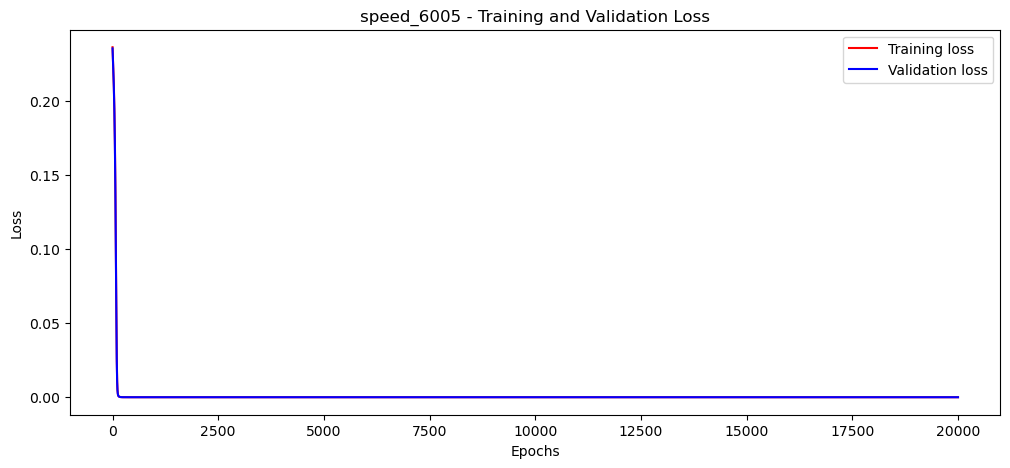

Reconstruction Error: 0.00505
List of Anomaly indexes: [6, 11, 24, 25, 34, 38, 43, 62, 79, 96, 126, 131, 140, 141, 197, 232, 236, 254, 256, 284, 299, 316, 329, 344, 373, 375, 385, 424, 456, 525, 563, 618, 640, 666, 678, 714, 736, 752, 753, 756, 780, 784, 790, 839, 896, 898, 903, 914, 915, 916, 1093, 1138, 1147, 1192, 1196, 1231, 1242, 1243, 1261, 1263, 1264, 1265, 1318, 1368, 1414, 1417, 1439, 1513, 1577, 1606, 1651, 1686, 1721, 1751, 1773, 1799, 1824, 1825, 1827, 1838, 1910, 1995, 1999, 2083, 2089, 2090, 2106, 2108, 2151, 2154, 2163, 2179, 2184, 2240, 2265, 2267, 2268, 2270, 2287, 2296, 2297, 2308, 2313, 2318, 2335, 2336, 2384, 2386, 2389, 2391, 2393, 2394, 2407, 2410, 2480]
Number of Anomalies: 115


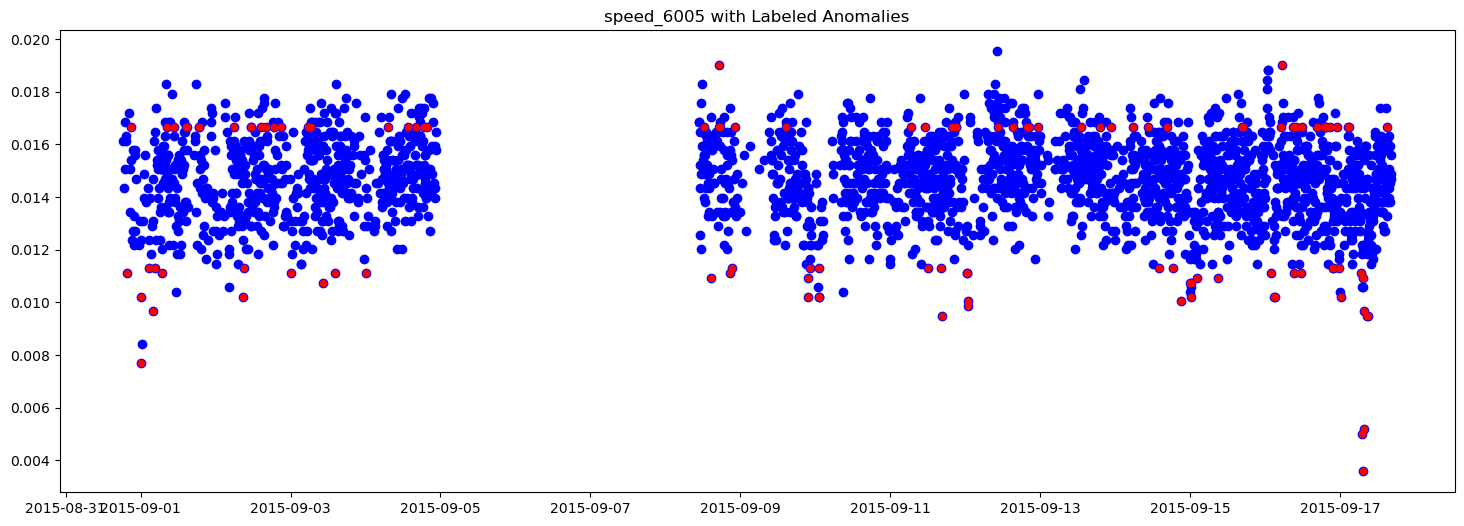

Training and Evaluation for the speed_7578 dataset
Epoch  1000 | Train Loss: 0.0000044145 | Val Loss: 0.0000044128
Epoch  2000 | Train Loss: 0.0000040559 | Val Loss: 0.0000040558
Epoch  3000 | Train Loss: 0.0000039407 | Val Loss: 0.0000039406
Epoch  4000 | Train Loss: 0.0000037714 | Val Loss: 0.0000037712
Epoch  5000 | Train Loss: 0.0000035144 | Val Loss: 0.0000035141
Epoch  6000 | Train Loss: 0.0000030793 | Val Loss: 0.0000030787
Epoch  7000 | Train Loss: 0.0000022836 | Val Loss: 0.0000022827
Epoch  8000 | Train Loss: 0.0000018605 | Val Loss: 0.0000018604
Epoch  9000 | Train Loss: 0.0000016825 | Val Loss: 0.0000016825
Epoch 10000 | Train Loss: 0.0000012351 | Val Loss: 0.0000012348
Epoch 11000 | Train Loss: 0.0000010426 | Val Loss: 0.0000010425
Epoch 12000 | Train Loss: 0.0000009669 | Val Loss: 0.0000009668
Epoch 13000 | Train Loss: 0.0000009032 | Val Loss: 0.0000009031
Epoch 14000 | Train Loss: 0.0000008335 | Val Loss: 0.0000008334
Epoch 15000 | Train Loss: 0.0000007743 | Val Loss: 0.

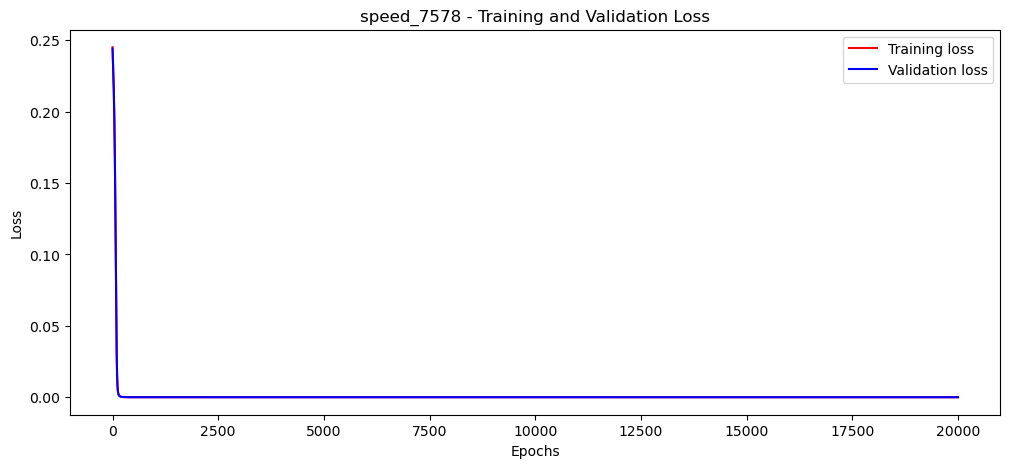

Reconstruction Error: 0.00062
List of Anomaly indexes: [317, 631, 751, 930, 961, 1123]
Number of Anomalies: 6


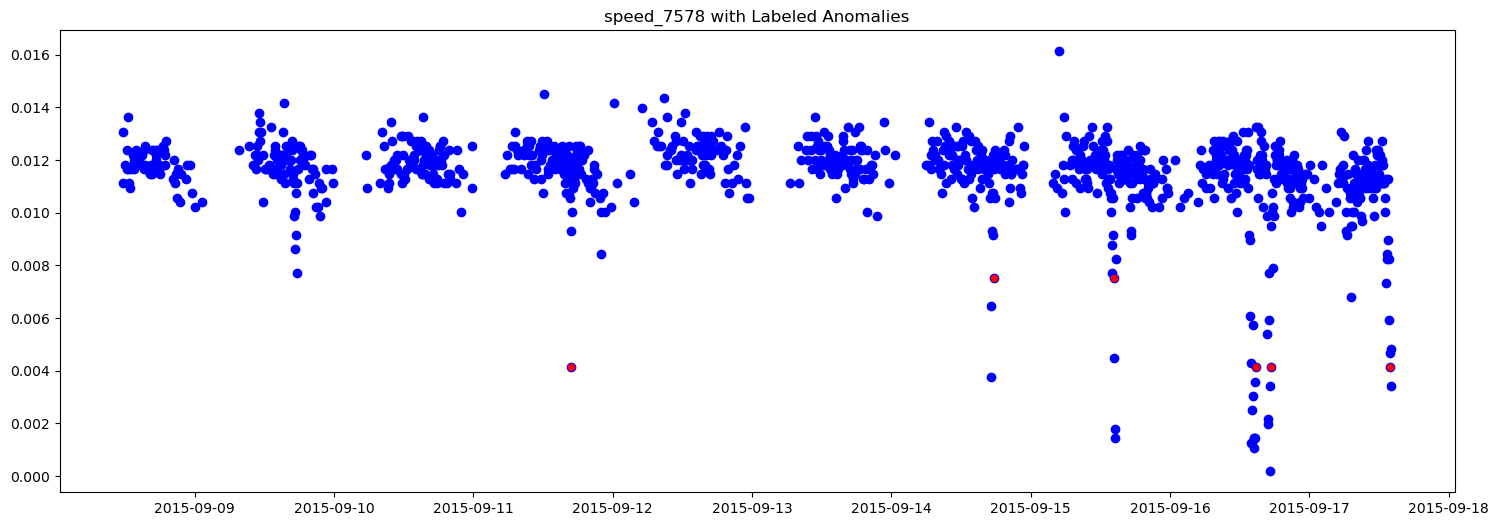

Training and Evaluation for the speed_t4013 dataset
Epoch  1000 | Train Loss: 0.0000014855 | Val Loss: 0.0000014855
Epoch  2000 | Train Loss: 0.0000014828 | Val Loss: 0.0000014828
Epoch  3000 | Train Loss: 0.0000014782 | Val Loss: 0.0000014782
Epoch  4000 | Train Loss: 0.0000014706 | Val Loss: 0.0000014706
Epoch  5000 | Train Loss: 0.0000014579 | Val Loss: 0.0000014579
Epoch  6000 | Train Loss: 0.0000014367 | Val Loss: 0.0000014367
Epoch  7000 | Train Loss: 0.0000013990 | Val Loss: 0.0000013990
Epoch  8000 | Train Loss: 0.0000013198 | Val Loss: 0.0000013197
Epoch  9000 | Train Loss: 0.0000011550 | Val Loss: 0.0000011548
Epoch 10000 | Train Loss: 0.0000009413 | Val Loss: 0.0000009411
Epoch 11000 | Train Loss: 0.0000007679 | Val Loss: 0.0000007678
Epoch 12000 | Train Loss: 0.0000006551 | Val Loss: 0.0000006550
Epoch 13000 | Train Loss: 0.0000006060 | Val Loss: 0.0000006060
Epoch 14000 | Train Loss: 0.0000005904 | Val Loss: 0.0000005904
Epoch 15000 | Train Loss: 0.0000005830 | Val Loss: 0

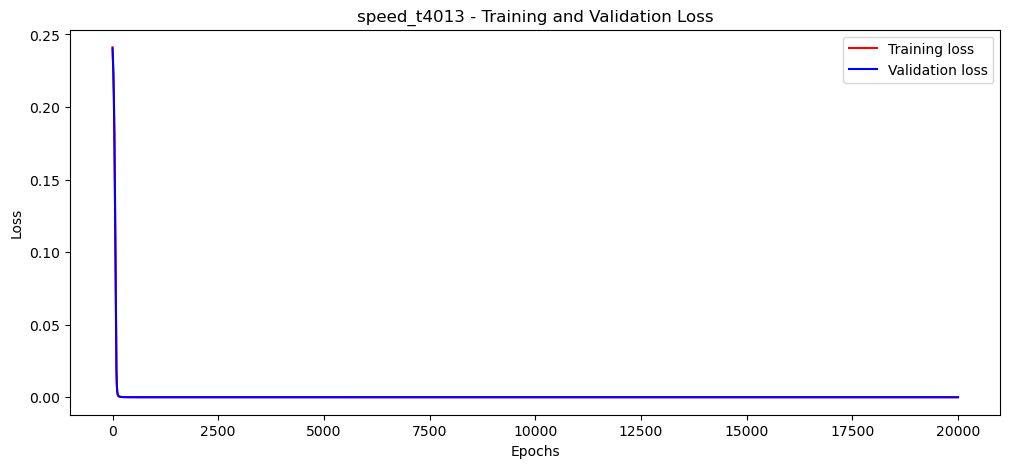

Reconstruction Error: 0.00133
List of Anomaly indexes: [54, 55, 56, 136, 140, 141, 2146, 2147, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2399]
Number of Anomalies: 16


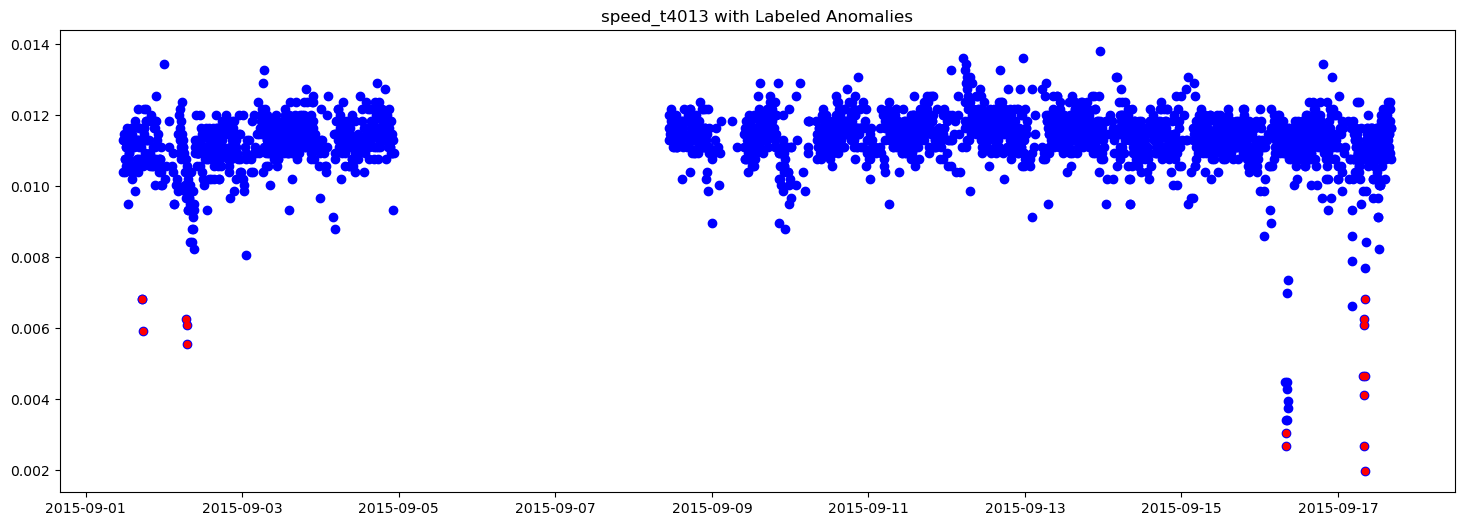

Training and Evaluation for the TravelTime_387 dataset
Epoch  1000 | Train Loss: 0.0035190540 | Val Loss: 0.0035134950
Epoch  2000 | Train Loss: 0.0015366845 | Val Loss: 0.0015356266
Epoch  3000 | Train Loss: 0.0007104127 | Val Loss: 0.0007095568
Epoch  4000 | Train Loss: 0.0003674835 | Val Loss: 0.0003672932
Epoch  5000 | Train Loss: 0.0002530215 | Val Loss: 0.0002529844
Epoch  6000 | Train Loss: 0.0001787908 | Val Loss: 0.0001786782
Epoch  7000 | Train Loss: 0.0001405484 | Val Loss: 0.0001405160
Epoch  8000 | Train Loss: 0.0001064151 | Val Loss: 0.0001064312
Epoch  9000 | Train Loss: 0.0000794226 | Val Loss: 0.0000793713
Epoch 10000 | Train Loss: 0.0000560544 | Val Loss: 0.0000560477
Epoch 11000 | Train Loss: 0.0000436083 | Val Loss: 0.0000435712
Epoch 12000 | Train Loss: 0.0000361111 | Val Loss: 0.0000360792
Epoch 13000 | Train Loss: 0.0000309207 | Val Loss: 0.0000309209
Epoch 14000 | Train Loss: 0.0000261806 | Val Loss: 0.0000261793
Epoch 15000 | Train Loss: 0.0000233334 | Val Loss

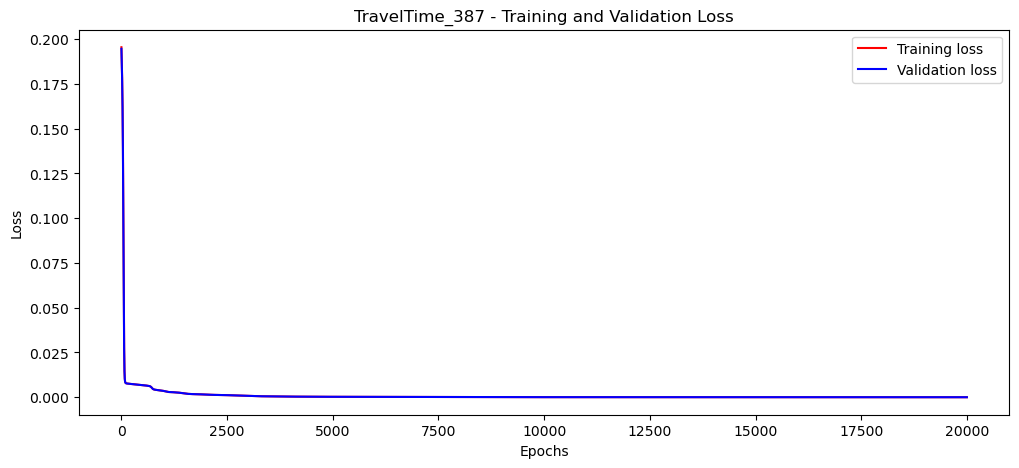

Reconstruction Error: 0.05078
List of Anomaly indexes: [37, 83, 89, 91, 106, 132, 149, 172, 200, 203, 204, 206, 207, 220, 231, 240, 246, 247, 248, 250, 300, 307, 327, 364, 366, 378, 389, 401, 408, 409, 490, 587, 604, 689, 703, 723, 752, 789, 802, 813, 859, 883, 895, 898, 924, 969, 979, 988, 992, 1024, 1123, 1145, 1175, 1179, 1189, 1190, 1288, 1289, 1344, 1388, 1389, 1566, 1599, 1668, 1689, 1754, 1760, 1765, 1789, 1817, 1825, 1829, 1839, 1846, 1871, 1879, 1882, 1888, 1925, 1932, 1946, 1947, 1983, 1984, 2011, 2031, 2089, 2108, 2110, 2111, 2121, 2124, 2153, 2164, 2185, 2203, 2216, 2230, 2238, 2256, 2257, 2262, 2287, 2289, 2295, 2301, 2309, 2314, 2341, 2349, 2356, 2358, 2360, 2367, 2370, 2389, 2410, 2415, 2418, 2473, 2489]
Number of Anomalies: 121


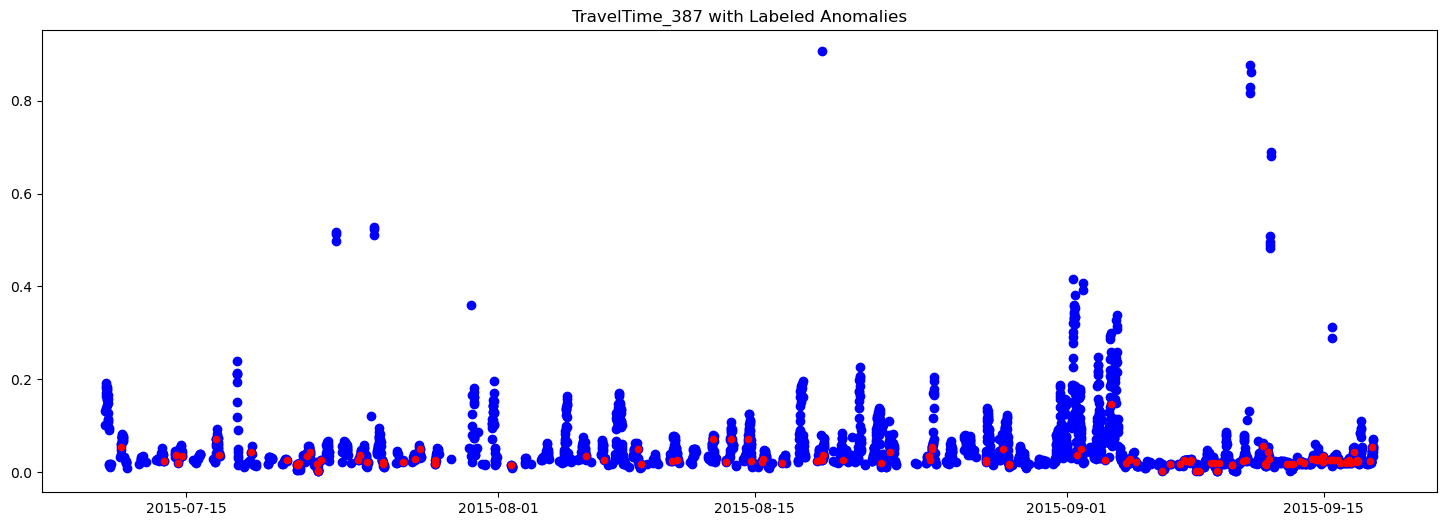

Training and Evaluation for the TravelTime_451 dataset
Epoch  1000 | Train Loss: 0.0027811415 | Val Loss: 0.0027793273
Epoch  2000 | Train Loss: 0.0011448014 | Val Loss: 0.0011443096
Epoch  3000 | Train Loss: 0.0007676177 | Val Loss: 0.0007673087
Epoch  4000 | Train Loss: 0.0004228870 | Val Loss: 0.0004226480
Epoch  5000 | Train Loss: 0.0002507516 | Val Loss: 0.0002506014
Epoch  6000 | Train Loss: 0.0001606903 | Val Loss: 0.0001606520
Epoch  7000 | Train Loss: 0.0001034246 | Val Loss: 0.0001033319
Epoch  8000 | Train Loss: 0.0000645195 | Val Loss: 0.0000644669
Epoch  9000 | Train Loss: 0.0000464713 | Val Loss: 0.0000464622
Epoch 10000 | Train Loss: 0.0000385835 | Val Loss: 0.0000386038
Epoch 11000 | Train Loss: 0.0000324703 | Val Loss: 0.0000326344
Epoch 12000 | Train Loss: 0.0000284667 | Val Loss: 0.0000285107
Epoch 13000 | Train Loss: 0.0000240582 | Val Loss: 0.0000240643
Epoch 14000 | Train Loss: 0.0000215258 | Val Loss: 0.0000215257
Epoch 15000 | Train Loss: 0.0000198606 | Val Loss

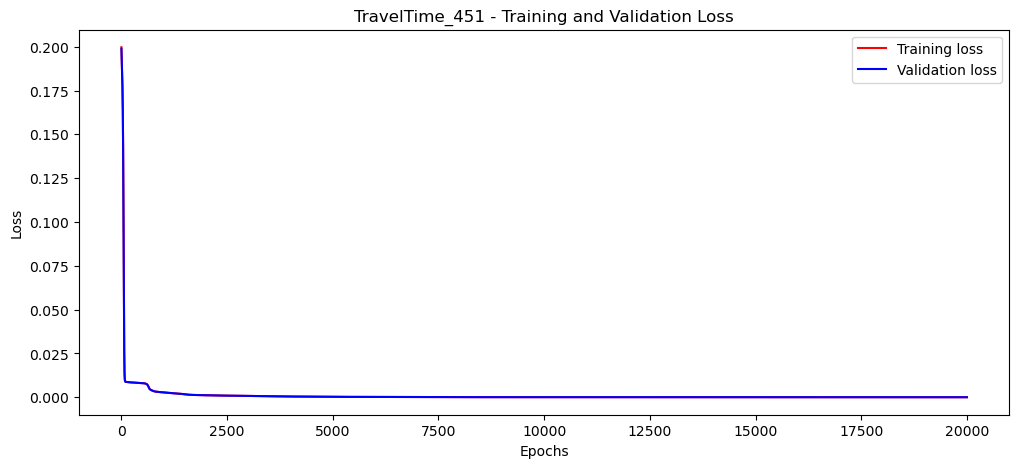

Reconstruction Error: 0.03345
List of Anomaly indexes: [4, 5, 7, 15, 17, 27, 31, 34, 38, 59, 81, 82, 91, 92, 93, 95, 98, 101, 105, 106, 108, 131, 132, 144, 181, 185, 228, 230, 232, 247, 248, 269, 270, 288, 290, 293, 313, 316, 317, 318, 319, 344, 371, 374, 392, 409, 414, 418, 419, 432, 438, 441, 445, 448, 454, 457, 459, 460, 478, 483, 516, 518, 526, 532, 544, 545, 548, 557, 607, 617, 645, 648, 650, 682, 694, 695, 701, 723, 725, 727, 732, 767, 779, 808, 815, 818, 838, 840, 849, 850, 852, 877, 880, 932, 946, 962, 978, 986, 987, 1008, 1009, 1013, 1016, 1039, 1045, 1048, 1089, 1132, 1139, 1152, 1172, 1185, 1190, 1192, 1207, 1209, 1233, 1247, 1248, 1251, 1255, 1276, 1285, 1287, 1290, 1304, 1309, 1312, 1341, 1362, 1364, 1373, 1390, 1391, 1393, 1394, 1434, 1443, 1448, 1455, 1463, 1485, 1486, 1488, 1494, 1495, 1501, 1506, 1515, 1532, 1535, 1558, 1560, 1570, 1600, 1609, 1610, 1646, 1648, 1671, 1672, 1688, 1698, 1738, 1746, 1752, 1761, 1769, 1774, 1781, 1795, 1796, 1802, 1803, 1811, 1815, 1821, 1

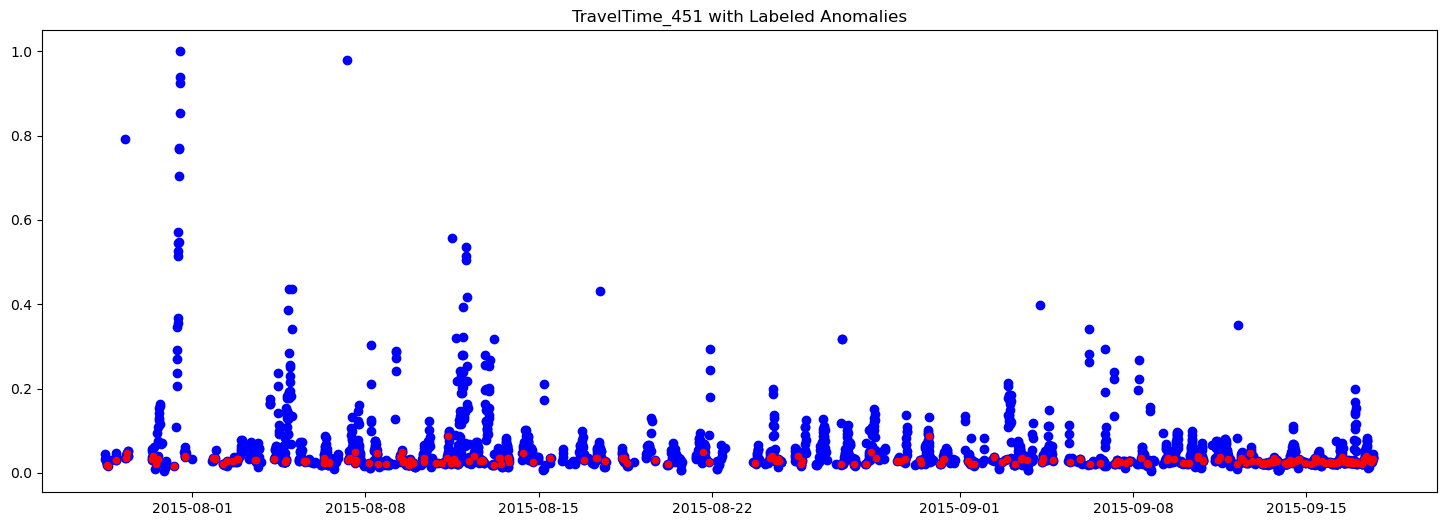

In [66]:
dataset_evaluation(dataset_list)

## **References**

- https://www.kaggle.com/datasets/boltzmannbrain/nab
- https://www.kaggle.com/code/krzysztofchodara/realtrafic-anomaly-detection
- https://www.kaggle.com/code/benroshan/anomaly-detection-among-us
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
